In [25]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Leer los datos en python

In [3]:
# Leer 3 datasets de csv
df1 = pd.read_csv('Precios2021.csv', sep=';')
df2 = pd.read_csv('Precios2022.csv', sep=';')
df3 = pd.read_csv('Precios2023.csv', sep=';')

# Juntar los 3 datasets en uno solo
data = pd.concat([df1, df2, df3])

data.head()

#Guardarlo en Csv
data.to_csv('Precios.csv', index=False)

In [4]:
# Parece que el mes está en formato abreviado en español. Vamos a convertirlo a inglés para que Pandas pueda reconocerlo.
months_mapping = {
    "ene": "Jan",
    "feb": "Feb",
    "mar": "Mar",
    "abr": "Apr",
    "may": "May",
    "jun": "Jun",
    "jul": "Jul",
    "ago": "Aug",
    "sep": "Sep",
    "oct": "Oct",
    "nov": "Nov",
    "dic": "Dec",
}

for es, en in months_mapping.items():
    data['FECHA'] = data['FECHA'].str.replace(f'-{es}-', f'-{en}-')

# Intentamos convertir la columna "FECHA" nuevamente
data['FECHA'] = pd.to_datetime(data['FECHA'], dayfirst=True)

# Dividimos los datos nuevamente en conjuntos de entrenamiento y prueba
train_data = data[data['FECHA'] <= '2023-03-31']['Superior']
test_data = data[(data['FECHA'] > '2023-03-31') & (data['FECHA'] <= '2023-06-30')]['Superior']

# Verificamos los datos de entrenamiento y prueba
train_data.tail(), test_data.head()


C:\Users\angel\AppData\Local\Temp\ipykernel_4920\1537977720.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['FECHA'] = pd.to_datetime(data['FECHA'], dayfirst=True)


(85    33.49
 86    33.49
 87    33.49
 88    33.49
 89    33.49
 Name: Superior, dtype: float64,
 90    33.49
 91    33.49
 92    34.46
 93    34.46
 94    34.46
 Name: Superior, dtype: float64)

## Normalizamos el precio del combustible

In [5]:


# Función para convertir la serie de tiempo en secuencias de entrada y salida
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

# Normalizamos los datos utilizando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Creamos secuencias para los datos de entrenamiento
seq_length = 10
X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Verificamos las dimensiones de las secuencias creadas
X_train.shape, y_train.shape


((810, 10, 1), (810, 1))

## Definicion De modelo

In [6]:

# Definición de la arquitectura de la red neuronal
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length, num_layers=2):
        super(TimeSeriesPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        lstm_out = lstm_out[:, -1, :]
        output = self.linear(lstm_out)

        return output

# Parámetros
input_dim = 1
hidden_dim = 50
num_layers = 2

# Instanciamos el modelo
model = TimeSeriesPredictor(input_dim, hidden_dim, seq_length, num_layers)

# Verificamos la arquitectura de la red
model


TimeSeriesPredictor(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Entrenamiento del primer Modelo

In [7]:

# Hiperparámetros
batch_size = 32
epochs = 100
learning_rate = 0.001

# Convertimos los datos a tensores de PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Función de pérdida y optimizador
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento
model.train()
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Imprimimos el progreso
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

print("Entrenamiento completado.")


Epoch [10/100], Loss: 0.0009
Epoch [20/100], Loss: 0.0018
Epoch [30/100], Loss: 0.0007
Epoch [40/100], Loss: 0.0026
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0003
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0005
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0004
Entrenamiento completado.


In [8]:
# Normalizamos y creamos secuencias para los datos de prueba
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test, y_test = create_sequences(scaled_test_data, seq_length)

# Convertimos los datos de prueba a tensores de PyTorch
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluación del modelo en los datos de prueba
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)
        test_loss += loss.item()

# Calculamos la pérdida promedio en los datos de prueba
test_loss /= len(test_loader)
test_loss


0.00017999643265890578

## Predicciones del Primero Modelo

In [12]:
# Corregimos la función de predicción haciendo una copia de la secuencia actual antes de actualizarla
def predict_future(model, last_sequence, future_steps):
    future_predictions = []
    current_sequence = last_sequence.clone().detach()
    
    model.eval()
    with torch.no_grad():
        for i in range(future_steps):
            prediction = model(current_sequence)
            future_predictions.append(prediction.item())
            # Creamos una copia de la secuencia actual antes de actualizarla
            new_sequence = current_sequence.clone()
            new_sequence[0, :-1, 0] = current_sequence[0, 1:, 0]
            new_sequence[0, -1, 0] = prediction
            current_sequence = new_sequence
        
    return future_predictions

# Última secuencia disponible en los datos (hasta junio de 2023)
last_sequence = torch.tensor(scaled_test_data[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32)

# Número de días a predecir para junio, julio y agosto (considerando 30 días por mes)
future_steps = 90

# Hacemos las predicciones nuevamente
future_predictions_scaled = predict_future(model, last_sequence, future_steps)
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Dividimos las predicciones en junio, julio y agosto
predictions_june = future_predictions[:30]
predictions_july = future_predictions[30:60]
predictions_august = future_predictions[60:]

# Resultados
predictions_june.mean(), predictions_july.mean(), predictions_august.mean()


(33.250892745107414, 31.25272897854447, 29.442880653768775)

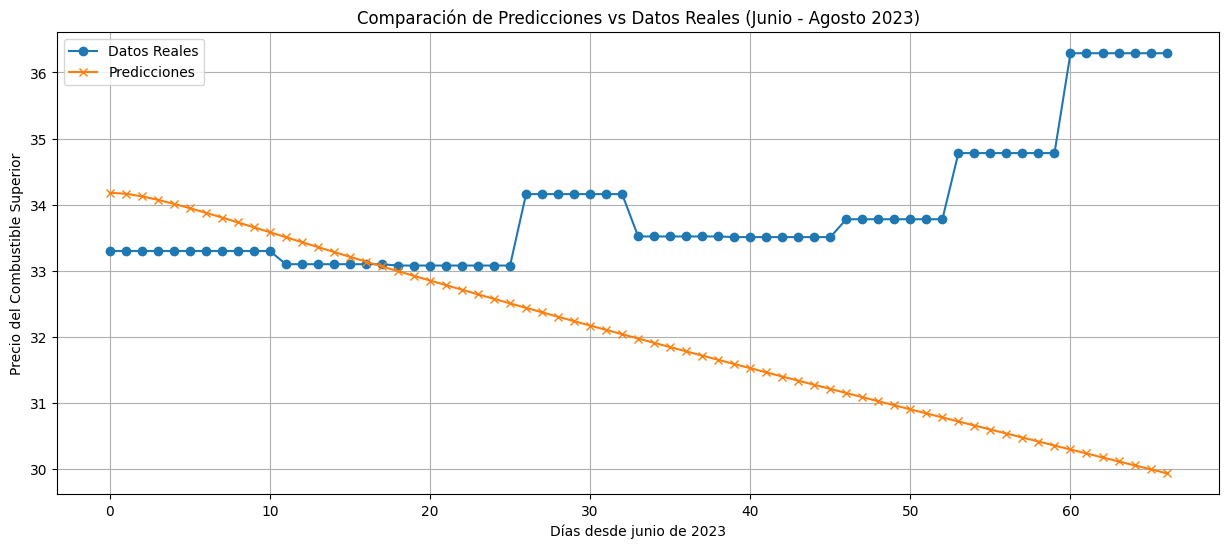

In [13]:


# Extraemos los datos reales para junio, julio y principios de agosto
real_data_june_july_august = data[(data['FECHA'] > '2023-05-31') & (data['FECHA'] <= '2023-08-31')]['Superior'].values

# Concatenamos las predicciones para estos meses
predicted_data_june_july_august = np.concatenate([predictions_june, predictions_july, predictions_august])

# Truncamos las predicciones para que coincidan con la longitud de los datos reales (si es necesario)
predicted_data_june_july_august = predicted_data_june_july_august[:len(real_data_june_july_august)]

# Gráfica comparando las predicciones con los datos reales
plt.figure(figsize=(15, 6))
plt.plot(real_data_june_july_august, label='Datos Reales', marker='o')
plt.plot(predicted_data_june_july_august, label='Predicciones', marker='x')
plt.xlabel('Días desde junio de 2023')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Predicciones vs Datos Reales (Junio - Agosto 2023)')
plt.legend()
plt.grid(True)
plt.show()


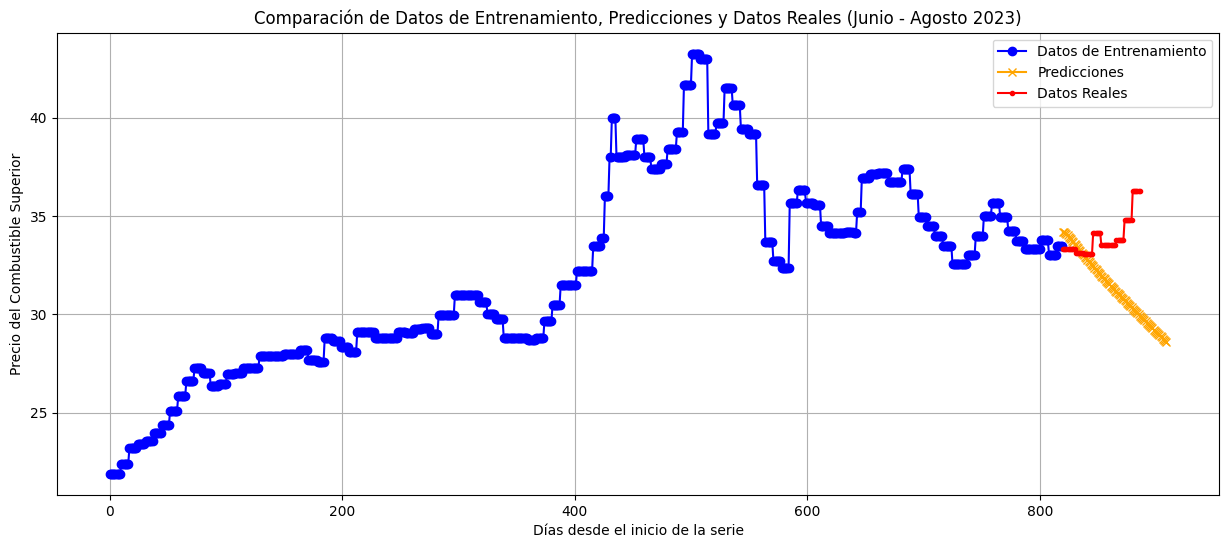

In [14]:

# Datos de entrenamiento
train_data_visualization = train_data.values

# Concatenar las predicciones para junio, julio y agosto
predicted_data_june_july_august = np.concatenate([predictions_june, predictions_july, predictions_august])

# Gráfica comparando los datos de entrenamiento, predicciones y datos reales
plt.figure(figsize=(15, 6))
plt.plot(train_data_visualization, label='Datos de Entrenamiento', marker='o', color='blue')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(predicted_data_june_july_august)), 
         predicted_data_june_july_august, label='Predicciones', marker='x', color='orange')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(real_data_june_july_august)), 
         real_data_june_july_august, label='Datos Reales', marker='.', color='red')
plt.xlabel('Días desde el inicio de la serie')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Datos de Entrenamiento, Predicciones y Datos Reales (Junio - Agosto 2023)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:


# Calculamos el MSE y RMSE
mse = mean_squared_error(real_data_june_july_august, predicted_data_june_july_august[:len(real_data_june_july_august)])
rmse = mean_squared_error(real_data_june_july_august, predicted_data_june_july_august[:len(real_data_june_july_august)], squared=False)

# Calculamos el coeficiente de determinación (R^2)
r2 = r2_score(real_data_june_july_august, predicted_data_june_july_august[:len(real_data_june_july_august)])

mse, rmse, r2


(7.8940876485240015, 2.809641907525584, -7.568068441292427)


El modelo no se ajusto muy bien a los datos y tiene un R^2 de -7.57 lo cual es muy malo. Esto se debe a que el modelo no es el adecuado para los datos que se tienen. Se puede ver que el modelo no se ajusta bien a los datos en la grafica de abajo. Esto debido a que los datos tienen una seccion atipica por lo que vamos a remplazar esos datos por la media mas la interpolacion de los datos.

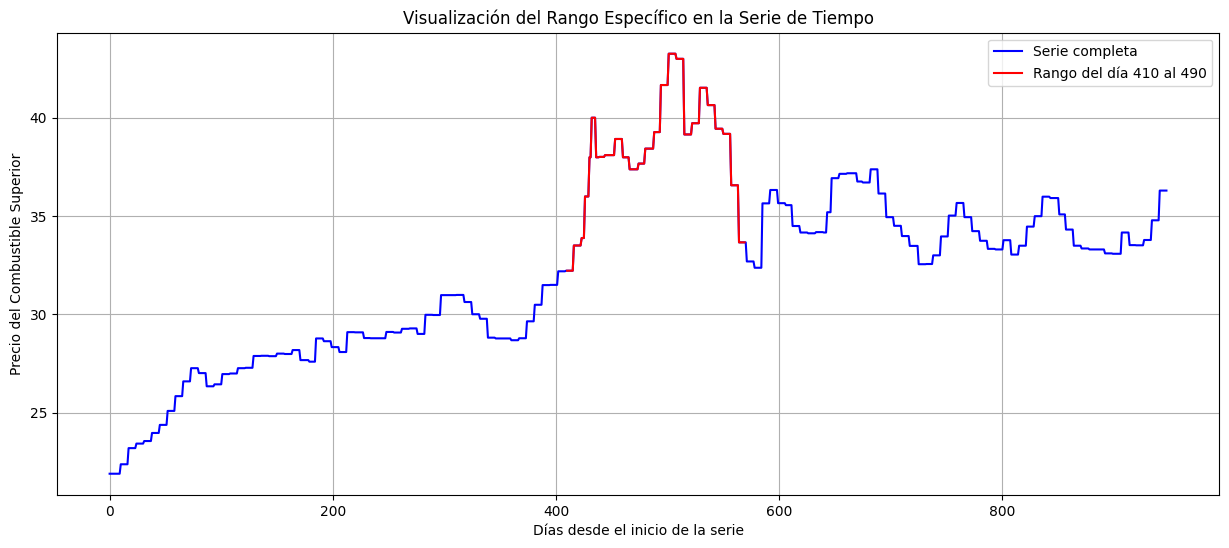

(45   2022-02-15
 46   2022-02-16
 47   2022-02-17
 48   2022-02-18
 49   2022-02-19
 Name: FECHA, dtype: datetime64[ns],
 180   2022-06-30
 181   2022-07-01
 182   2022-07-02
 183   2022-07-03
 184   2022-07-04
 Name: FECHA, dtype: datetime64[ns])

In [16]:
# Visualizamos los datos en el rango especificado (del día 410 al 490)
plt.figure(figsize=(15, 6))
plt.plot(data['Superior'].values, label='Serie completa', color='blue')
plt.plot(range(410, 570), data['Superior'].values[410:570], label='Rango del día 410 al 490', color='red')
plt.xlabel('Días desde el inicio de la serie')
plt.ylabel('Precio del Combustible Superior')
plt.title('Visualización del Rango Específico en la Serie de Tiempo')
plt.legend()
plt.grid(True)
plt.show()

# Mostramos las fechas correspondientes a ese rango
date_range_to_remove = data.iloc[410:550]['FECHA']
date_range_to_remove.head(), date_range_to_remove.tail()


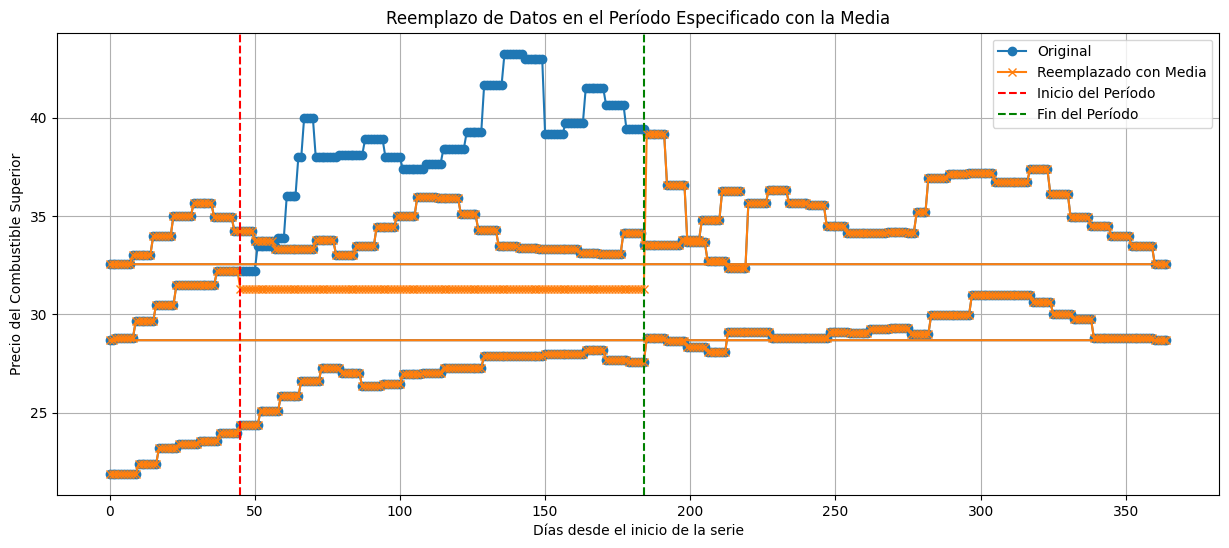

In [17]:

# Fecha de inicio y fin del rango a reemplazar
start_date = '2022-02-15'
end_date = '2022-07-04'

# Calculamos la media de los datos antes del período especificado
mean_before_period = data[data['FECHA'] < start_date]['Superior'].mean()

# Calculamos la media de los datos después del período especificado
mean_after_period = data[data['FECHA'] > end_date]['Superior'].mean()

# Calculamos la media de estos dos valores
final_mean = (mean_before_period + mean_after_period) / 2

# Reemplazamos los datos en el rango especificado con el valor medio
data_replaced = data.copy()
data_replaced.loc[(data['FECHA'] >= start_date) & (data['FECHA'] <= end_date), 'Superior'] = final_mean

# Mostramos una comparación antes y después del reemplazo
plt.figure(figsize=(15, 6))
plt.plot(data['Superior'], label='Original', marker='o')
plt.plot(data_replaced['Superior'], label='Reemplazado con Media', marker='x')
plt.axvline(x=data[data['FECHA'] == start_date].index[0], color='red', linestyle='--', label='Inicio del Período')
plt.axvline(x=data[data['FECHA'] == end_date].index[0], color='green', linestyle='--', label='Fin del Período')
plt.xlabel('Días desde el inicio de la serie')
plt.ylabel('Precio del Combustible Superior')
plt.title('Reemplazo de Datos en el Período Especificado con la Media')
plt.legend()
plt.grid(True)
plt.show()


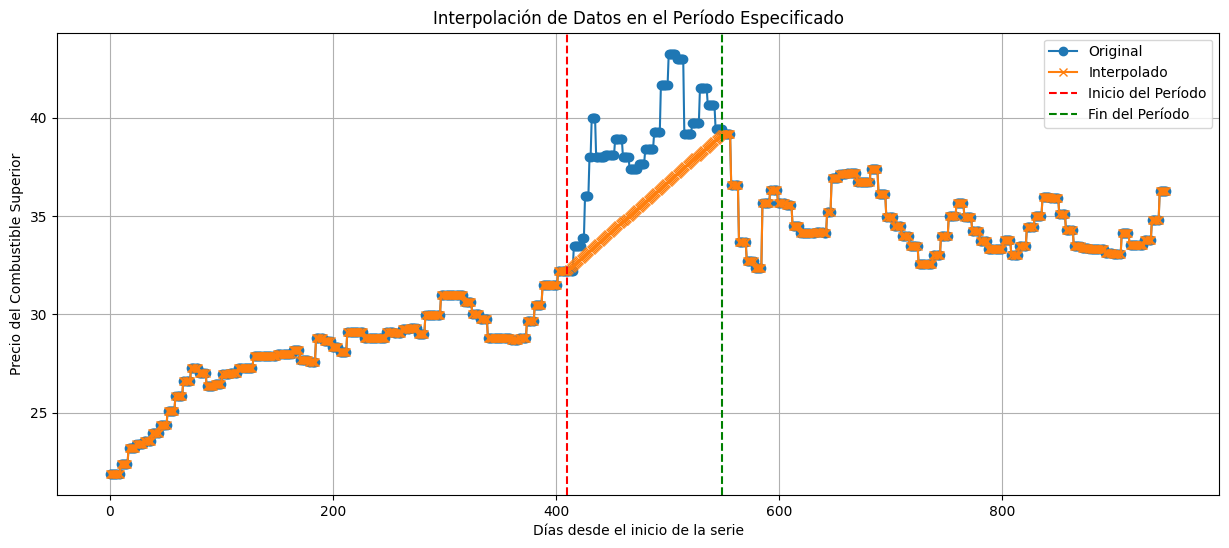

In [18]:
# Reseteamos el índice del DataFrame
data_reset_index = data.reset_index(drop=True)

# Encuentra los índices de inicio y fin del rango a reemplazar
start_idx = data_reset_index[data_reset_index['FECHA'] == start_date].index[0]
end_idx = data_reset_index[data_reset_index['FECHA'] == end_date].index[0]

# Valores antes y después del rango
value_before = data_reset_index.loc[start_idx - 1, 'Superior']
value_after = data_reset_index.loc[end_idx + 1, 'Superior']

# Interpolación lineal de los valores en el rango
interpolated_values = np.linspace(value_before, value_after, end_idx - start_idx + 1)

# Reemplazar los valores en el rango con los valores interpolados
data_interpolated = data_reset_index.copy()
data_interpolated.loc[start_idx:end_idx, 'Superior'] = interpolated_values

# Mostramos una comparación antes y después de la interpolación
plt.figure(figsize=(15, 6))
plt.plot(data_reset_index['Superior'], label='Original', marker='o')
plt.plot(data_interpolated['Superior'], label='Interpolado', marker='x')
plt.axvline(x=start_idx, color='red', linestyle='--', label='Inicio del Período')
plt.axvline(x=end_idx, color='green', linestyle='--', label='Fin del Período')
plt.xlabel('Días desde el inicio de la serie')
plt.ylabel('Precio del Combustible Superior')
plt.title('Interpolación de Datos en el Período Especificado')
plt.legend()
plt.grid(True)
plt.show()


## Obtenemos los datos para el segundo Modelo

In [19]:

# Eliminamos los datos en el rango de fechas especificado
data_filtered = data[(data['FECHA'] < start_date) | (data['FECHA'] > end_date)]

# Dividimos los datos nuevamente en conjuntos de entrenamiento y prueba
train_data_filtered = data_filtered[data_filtered['FECHA'] <= '2023-03-31']['Superior']
test_data_filtered = data_filtered[(data_filtered['FECHA'] > '2023-03-31') & (data_filtered['FECHA'] <= '2023-06-30')]['Superior']

# Normalizamos los datos utilizando el mismo scaler
scaled_train_data_filtered = scaler.transform(train_data_filtered.values.reshape(-1, 1))

# Creamos secuencias para los datos de entrenamiento
X_train_filtered, y_train_filtered = create_sequences(scaled_train_data_filtered, seq_length)

# Verificamos las dimensiones de las secuencias creadas
X_train_filtered.shape, y_train_filtered.shape

((670, 10, 1), (670, 1))

## Entrenamos el modelo 2

In [20]:
# Convertimos los nuevos datos de entrenamiento a tensores de PyTorch
train_dataset_filtered = TensorDataset(torch.tensor(X_train_filtered, dtype=torch.float32), torch.tensor(y_train_filtered, dtype=torch.float32))
train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)

# Instanciamos el modelo con la misma configuración
model_filtered = TimeSeriesPredictor(input_dim, hidden_dim, seq_length, num_layers)

# Optimizador
optimizer_filtered = torch.optim.Adam(model_filtered.parameters(), lr=learning_rate)

# Entrenamiento con los datos filtrados
model_filtered.train()
for epoch in range(epochs):
    for batch_X, batch_y in train_loader_filtered:
        # Forward pass
        predictions = model_filtered(batch_X)
        loss = loss_function(predictions, batch_y)

        # Backward pass y optimización
        optimizer_filtered.zero_grad()
        loss.backward()
        optimizer_filtered.step()

# Preparamos los datos de prueba
scaled_test_data_filtered = scaler.transform(test_data_filtered.values.reshape(-1, 1))
X_test_filtered, _ = create_sequences(scaled_test_data_filtered, seq_length)
last_sequence_filtered = torch.tensor(X_test_filtered[-1:], dtype=torch.float32)

# Hacemos las predicciones nuevamente
future_predictions_scaled_filtered = predict_future(model_filtered, last_sequence_filtered, future_steps)
future_predictions_filtered = scaler.inverse_transform(np.array(future_predictions_scaled_filtered).reshape(-1, 1))

# Dividimos las predicciones en junio, julio y agosto
predictions_june_filtered = future_predictions_filtered[:30]
predictions_july_filtered = future_predictions_filtered[30:60]
predictions_august_filtered = future_predictions_filtered[60:]

# Resultados
predictions_june_filtered.mean(), predictions_july_filtered.mean(), predictions_august_filtered.mean()


(33.18820191019774, 31.775618269234897, 30.64865677648783)

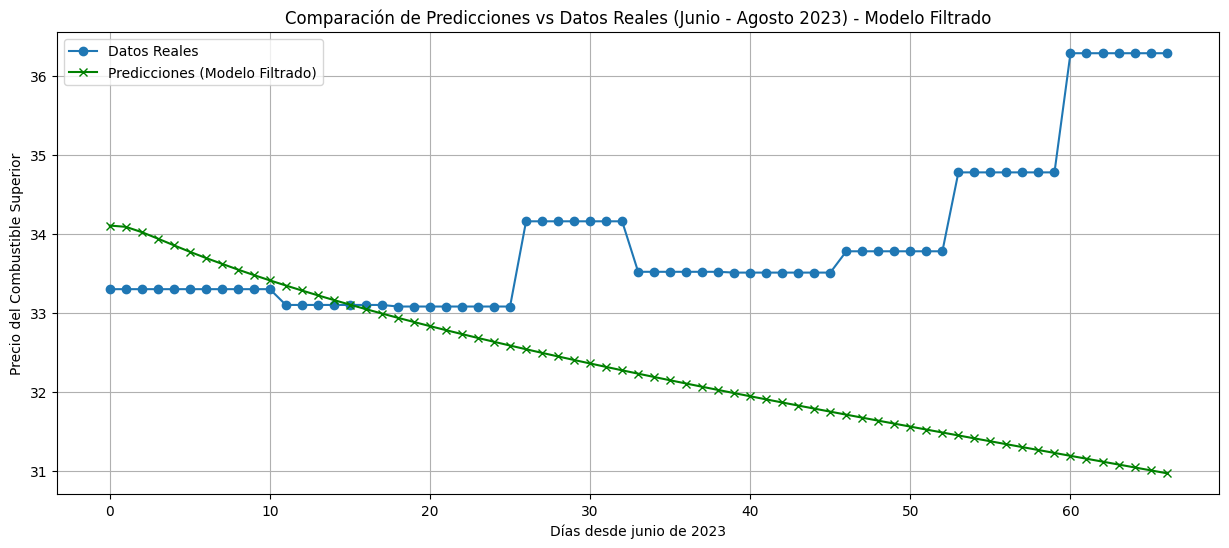

In [22]:

# Extraemos los datos reales para junio, julio y principios de agosto
real_data_june_july_august = data[(data['FECHA'] > '2023-05-31') & (data['FECHA'] <= '2023-08-31')]['Superior'].values

# Concatenamos las predicciones para estos meses (utilizando las predicciones del nuevo modelo)
predicted_data_june_july_august_filtered = np.concatenate([predictions_june_filtered, predictions_july_filtered, predictions_august_filtered])

# Truncamos las predicciones para que coincidan con la longitud de los datos reales (si es necesario)
predicted_data_june_july_august_filtered = predicted_data_june_july_august_filtered[:len(real_data_june_july_august)]

# Gráfica comparando las predicciones con los datos reales
plt.figure(figsize=(15, 6))
plt.plot(real_data_june_july_august, label='Datos Reales', marker='o')
plt.plot(predicted_data_june_july_august_filtered, label='Predicciones (Modelo Filtrado)', marker='x',color='green')
plt.xlabel('Días desde junio de 2023')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Predicciones vs Datos Reales (Junio - Agosto 2023) - Modelo Filtrado')
plt.legend()
plt.grid(True)
plt.show()


In [26]:


# Calculamos el MSE y RMSE
mse = mean_squared_error(real_data_june_july_august, predicted_data_june_july_august_filtered[:len(real_data_june_july_august)])
rmse = mean_squared_error(real_data_june_july_august, predicted_data_june_july_august_filtered[:len(real_data_june_july_august)], squared=False)

# Calculamos el coeficiente de determinación (R^2)
r2 = r2_score(real_data_june_july_august, predicted_data_june_july_august_filtered[:len(real_data_june_july_august)])

mse, rmse, r2


(5.421586880649963, 2.328430132224277, -4.884470697827566)

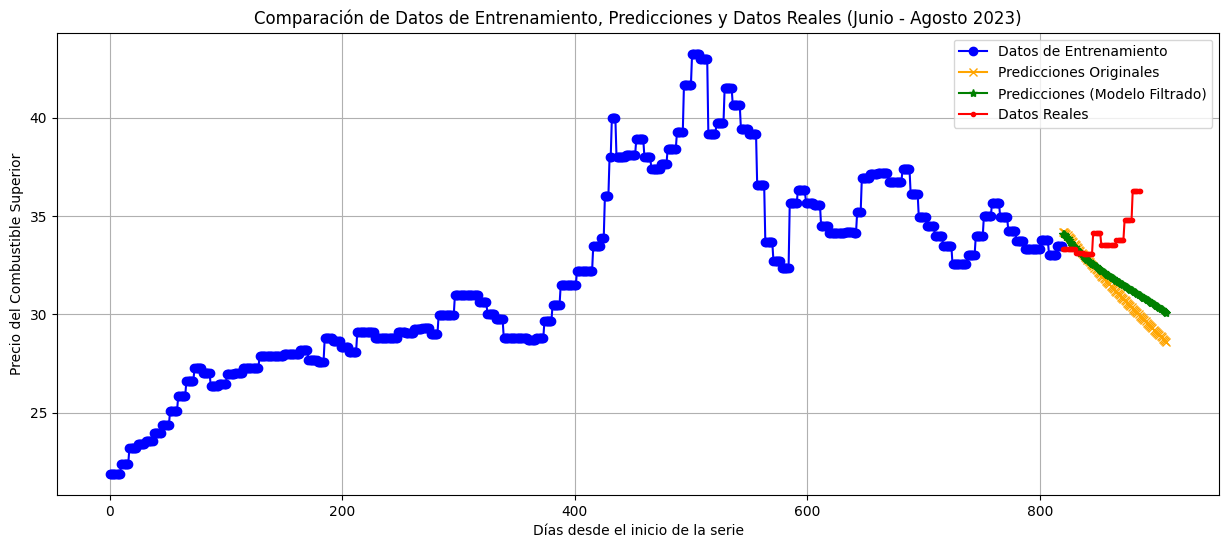

In [23]:

# Datos de entrenamiento
train_data_visualization = train_data.values

# Concatenar las predicciones originales para junio, julio y agosto
predicted_data_june_july_august = np.concatenate([predictions_june, predictions_july, predictions_august])

# Concatenar las nuevas predicciones (modelo filtrado) para junio, julio y agosto
predicted_data_june_july_august_filtered = np.concatenate([predictions_june_filtered, predictions_july_filtered, predictions_august_filtered])

# Gráfica comparando los datos de entrenamiento, ambas predicciones y datos reales
plt.figure(figsize=(15, 6))
plt.plot(train_data_visualization, label='Datos de Entrenamiento', marker='o', color='blue')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(predicted_data_june_july_august)), 
         predicted_data_june_july_august, label='Predicciones Originales', marker='x', color='orange')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(predicted_data_june_july_august_filtered)), 
         predicted_data_june_july_august_filtered, label='Predicciones (Modelo Filtrado)', marker='*', color='green')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(real_data_june_july_august)), 
         real_data_june_july_august, label='Datos Reales', marker='.', color='red')
plt.xlabel('Días desde el inicio de la serie')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Datos de Entrenamiento, Predicciones y Datos Reales (Junio - Agosto 2023)')
plt.legend()
plt.grid(True)
plt.show()


Observando la graficas de las predicciones contra los datos reales se puede observar que el modelo no es muy bueno, ya que no se ajusta bien a los datos reales. Esto se puede deber a que el modelo no es el adecuado para este tipo de datos, o que los datos no son los adecuados para este modelo. Los datos reales tienen una tendencia diferente a los predichos por el modelo de LTSM y por lo tanto no se ajustan bien a los datos reales.